In [1]:
import os
import pandas as pd

# Load the CSV files
df_1 = pd.read_csv('daily_report.csv')
df_2 = pd.read_csv('trades.csv')
df_3 = pd.read_csv('login.csv')

In [2]:
#Clean Data
df_2['open_time'] = pd.to_datetime(df_2['open_time'], unit='s')
df_2['open_time'] = df_2['open_time'].dt.tz_localize('UTC')
df_2['open_time'] = df_2['open_time'].dt.tz_localize(None)
df_2['close_time'] = pd.to_datetime(df_2['close_time'], unit='s')
df_2['close_time'] = df_2['close_time'].dt.tz_localize('UTC')
df_2['close_time'] = df_2['close_time'].dt.tz_localize(None)
df_2 = pd.merge(df_2, df_3[['login', 'account_currency']], on='login', how='left')


In [3]:
#Create Junction Table for changing profit to USD
currency_abreviation = df_2['account_currency'].tolist()
curr_to_US = ["AUD", "EUR", "GBP", "NZD"]
curr_from_US = ["CAD", "CHF", "CNH", "HKD", "HUF", "JPY", "MXN", "NLK", "PLN", "SEK", "SGD", "THB", "TRY", "ZAR"]
curr_US = ["USD"]
curr_reader = []

for currency in currency_abreviation:
    if currency in curr_to_US:
        curr_reader.append(f"{currency}USD.csv")
    elif currency in curr_from_US:
        curr_reader.append(f"USD{currency}.csv")
    elif currency in curr_US:
        curr_reader.append("USDUSD") 
    else: curr_reader.append(None) # Handle unexpected currencies
        
close_dates = df_2['close_time'].apply(lambda x: x.strftime('%Y.%m.%d 00:00')).tolist()
ticket_exch = df_2['ticket'].tolist()
profit_changer = list(zip(ticket_exch, curr_reader, close_dates))
df_4 = pd.DataFrame(profit_changer, columns=['ticket_exch', 'curr_reader', 'close_dates'])


In [4]:
df_4['close_math'] = None

for index, row in df_4.iterrows():
    ticket_exch = row['ticket_exch']
    curr_reader = row['curr_reader']
    close_dates = row['close_dates']
    
    if os.path.exists(curr_reader):
        curr_reader_df = pd.read_csv(curr_reader)
        if 'date' in curr_reader_df.columns and 'close' in curr_reader_df.columns:
            matched_row = curr_reader_df[curr_reader_df['date'] == close_dates]
            if not matched_row.empty:
                close_value = matched_row['close'].values[0]
                df_4.at[index, 'close_math'] = close_value 
            else: 
                df_4.at[index, 'close_math'] = 1 

df_4.head(10)


,ticket_exch,curr_reader,close_dates,close_math
0,68880703,EURUSD.csv,2024.02.15 00:00,1.07716
1,68880910,EURUSD.csv,2024.02.15 00:00,1.07716
2,68120690,GBPUSD.csv,2024.01.24 00:00,1.27241
3,68169249,GBPUSD.csv,2024.01.25 00:00,1.27072
4,68186877,USDUSD,2024.01.25 00:00,None
5,67824283,USDUSD,2024.01.16 00:00,None
6,68879706,EURUSD.csv,2024.02.15 00:00,1.07716
7,68089772,USDUSD,2024.01.24 00:00,None
8,67824307,USDUSD,2024.01.16 00:00,None
9,67824315,USDUSD,2024.01.15 00:00,None


In [5]:
profit_changer = df_2['profit'].tolist()
profit_math_changer = df_4['close_math'].tolist()

math_profit_changer = list(zip(profit_changer, profit_math_changer))
print(math_profit_changer[:10])

[(10.83, 1.07716), (23.16, 1.07716), (105.42, 1.27241), (485.26, 1.27072), (33.15, None), (0.0, None), (6.33, 1.07716), (2.94, None), (0.01, None), (0.0, None)]


In [8]:
profit_to_USD = []

for item in math_profit_changer:
    if item[1] is not None:
        if any(currency in curr_to_US for currency in currency_abreviation):
            prof_result = item[0] * item[1]
        elif any(currency in curr_from_US for currency in currency_abreviation):
            prof_result = item[0] / item[1]
        else:
            prof_result = item[0]
    else:
        prof_result = item[0]  
    profit_to_USD.append(prof_result)

print(profit_to_USD[:10])

[11.665642799999999, 24.947025599999996, 134.13746220000002, 616.6295872000001, 33.15, 0.0, 6.8184228, 2.94, 0.01, 0.0]


In [9]:
df_2['profit_USD'] = profit_to_USD
df_2.head(10)

,ticket,login,symbol,cmd,volume,open_time,open_price,close_time,close_price,tp,sl,reason,commission,swaps,profit,volume_usd,account_currency,profit_USD
0,68880703,7062462,XAUUSD,0,0.01,2024-02-13 17:05:41,1991.35000,2024-02-15 16:05:14,2003.01000,0.00000,0.00000,1,0.00,-1.12,10.83,3994.36,EUR,11.665643
1,68880910,7062462,XAUUSD,0,0.02,2024-02-13 17:08:49,1990.30000,2024-02-15 16:05:10,2002.76000,0.00000,0.00000,1,0.00,-2.25,23.16,7986.12,EUR,24.947026
2,68120690,813125,US2000,0,1.00,2024-01-24 07:56:45,1983.22000,2024-01-24 16:41:43,1996.68000,2012.34000,1980.03000,1,0.00,0.00,105.42,39799.00,GBP,134.137462
3,68169249,813125,US2000,0,2.00,2024-01-24 23:36:11,1960.62000,2024-01-25 16:29:03,1991.51000,2331.85000,1958.94000,1,0.00,-7.21,485.26,79042.60,GBP,616.629587
4,68186877,88945036,NZDUSD,0,0.13,2024-01-25 08:00:00,0.61062,2024-01-25 15:38:26,0.61317,0.61312,0.55059,1,-0.91,0.00,33.15,15909.27,USD,33.150000
5,67824283,7063824,XRPUSD,1,0.01,2024-01-15 22:01:00,0.57940,2024-01-16 00:17:16,0.57441,0.57444,0.58424,1,0.00,0.00,0.00,1.15,USD,0.000000
6,68879706,7062462,XAUUSD,0,0.02,2024-02-13 17:00:10,1995.38000,2024-02-15 14:49:53,1998.78000,0.00000,0.00000,1,0.00,-2.25,6.33,7988.32,EUR,6.818423
7,68089772,811046,GBPUSD,0,0.01,2024-01-23 17:00:01,1.26820,2024-01-24 10:17:34,1.27114,0.00000,1.27116,1,0.00,-0.02,2.94,2539.34,USD,2.940000
8,67824307,7063824,XRPUSD,1,0.01,2024-01-15 22:03:01,0.57964,2024-01-16 00:17:15,0.57452,0.57454,0.58434,1,0.00,0.00,0.01,1.15,USD,0.010000
9,67824315,7063824,XRPUSD,0,0.01,2024-01-15 22:05:05,0.58142,2024-01-15 22:51:12,0.57671,0.58652,0.57672,1,0.00,0.00,0.00,1.16,USD,0.000000


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

df_2['time_diff'] = (df_2['close_time'] - df_2['open_time']).dt.total_seconds()

df_2.head(10)

,ticket,login,symbol,cmd,volume,open_time,open_price,close_time,close_price,tp,sl,reason,commission,swaps,profit,volume_usd,account_currency,profit_USD,time_diff
0,68880703,7062462,XAUUSD,0,0.01,2024-02-13 17:05:41,1991.35000,2024-02-15 16:05:14,2003.01000,0.00000,0.00000,1,0.00,-1.12,10.83,3994.36,EUR,11.665643,169173.0
1,68880910,7062462,XAUUSD,0,0.02,2024-02-13 17:08:49,1990.30000,2024-02-15 16:05:10,2002.76000,0.00000,0.00000,1,0.00,-2.25,23.16,7986.12,EUR,24.947026,168981.0
2,68120690,813125,US2000,0,1.00,2024-01-24 07:56:45,1983.22000,2024-01-24 16:41:43,1996.68000,2012.34000,1980.03000,1,0.00,0.00,105.42,39799.00,GBP,134.137462,31498.0
3,68169249,813125,US2000,0,2.00,2024-01-24 23:36:11,1960.62000,2024-01-25 16:29:03,1991.51000,2331.85000,1958.94000,1,0.00,-7.21,485.26,79042.60,GBP,616.629587,60772.0
4,68186877,88945036,NZDUSD,0,0.13,2024-01-25 08:00:00,0.61062,2024-01-25 15:38:26,0.61317,0.61312,0.55059,1,-0.91,0.00,33.15,15909.27,USD,33.150000,27506.0
5,67824283,7063824,XRPUSD,1,0.01,2024-01-15 22:01:00,0.57940,2024-01-16 00:17:16,0.57441,0.57444,0.58424,1,0.00,0.00,0.00,1.15,USD,0.000000,8176.0
6,68879706,7062462,XAUUSD,0,0.02,2024-02-13 17:00:10,1995.38000,2024-02-15 14:49:53,1998.78000,0.00000,0.00000,1,0.00,-2.25,6.33,7988.32,EUR,6.818423,164983.0
7,68089772,811046,GBPUSD,0,0.01,2024-01-23 17:00:01,1.26820,2024-01-24 10:17:34,1.27114,0.00000,1.27116,1,0.00,-0.02,2.94,2539.34,USD,2.940000,62253.0
8,67824307,7063824,XRPUSD,1,0.01,2024-01-15 22:03:01,0.57964,2024-01-16 00:17:15,0.57452,0.57454,0.58434,1,0.00,0.00,0.01,1.15,USD,0.010000,8054.0
9,67824315,7063824,XRPUSD,0,0.01,2024-01-15 22:05:05,0.58142,2024-01-15 22:51:12,0.57671,0.58652,0.57672,1,0.00,0.00,0.00,1.16,USD,0.000000,2767.0


In [17]:
X = df_2[['time_diff']]
y = df_2['profit_USD']   

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

Mean Squared Error: 378625.30773926334
R^2 Score: 0.0001811053875543367
Intercept: 0.8952030701527331
Coefficient: -2.3453652553527138e-05


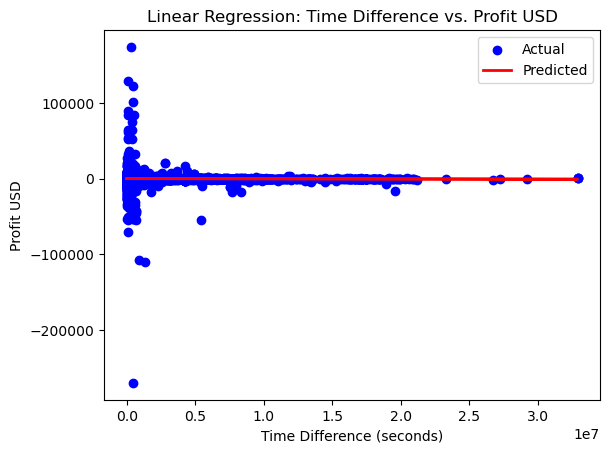

In [18]:
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

print(f'Intercept: {model.intercept_}')
print(f'Coefficient: {model.coef_[0]}')

import matplotlib.pyplot as plt

plt.scatter(X_test, y_test, color='blue', label='Actual')
plt.plot(X_test, y_pred, color='red', linewidth=2, label='Predicted')
plt.xlabel('Time Difference (seconds)')
plt.ylabel('Profit USD')
plt.title('Linear Regression: Time Difference vs. Profit USD')
plt.legend()
plt.show()